In [152]:
'''
test on a simple case
\Omega is the unit circle
\delta u = 1 
u=0 at border of \Omega
u=1/4*(x^2+y^2)-1/4
'''

import torch 
import torch.nn.functional as F
import numpy as np
import math
import matplotlib.pyplot as plt

torch.set_default_tensor_type('torch.FloatTensor')

m=10
learning_rate=1e-4  
iterations=8000  #default 10000
print_every_iter=100
beta=100 #coefficient for the regularization term in the loss expression, is set to be 1000 in section 3.1
n1=1000 #number of points in (0,1)^m
n2=100  #number of points on the border of (0,1)^m
n3=100  #number of points used for evaluating the error

class DeepRitzNet(torch.nn.Module):
    def __init__(self, m):
        super(DeepRitzNet, self).__init__()
        self.linear1=torch.nn.Linear(m,m)
        self.linear2=torch.nn.Linear(m,m)
        self.linear3=torch.nn.Linear(m,m)
        self.linear4=torch.nn.Linear(m,m)
        self.linear5=torch.nn.Linear(m,m)
        self.linear6=torch.nn.Linear(m,m)
        
        self.linear7=torch.nn.Linear(m,1)
    
    def forward(self, x):
        y=(F.relu(self.linear1(x)))**3
        y=(F.relu(self.linear2(x)))**3
        y+=x
        x=y
        y=(F.relu(self.linear3(x)))**3
        y=(F.relu(self.linear4(x)))**3
        y+=x
        x=y
        y=(F.relu(self.linear5(x)))**3
        y=(F.relu(self.linear6(x)))**3
        y+=x
        y=(F.relu(self.linear7(x)))**3
        return y

In [147]:
#U_groundtruth = 1/4*(x^2+y^2)-1/4
#take in a (m,) tensor (x, y, ...)
def U_groundtruth(t):
    re = (t[0]**2 + t[1]**2 - 1).item()/4
    return re

#turn a (2,) tensor/ndarray to a (m,) tensor
def zeropad(x_2):
    x_10=torch.zeros(m,)
    x_10[0]=x_2[0]
    x_10[1]=x_2[1]
    return x_10
    
#sample a (m,) tensor on the border of the unit circle
def on_sample():
    theta=np.random.rand()*2*math.pi
    re=np.zeros(m)
    re[0]=math.cos(theta)
    re[1]=math.sin(theta)
    re=torch.tensor(re,requires_grad=True)
    return re

#sample a (m,) tensor in the unit circle
def in_sample():
    r=np.random.rand()
    theta=np.random.rand()*2*math.pi
    re=np.zeros(m)
    re[0]=r*math.cos(theta)
    re[1]=r*math.sin(theta)
    re=torch.tensor(re,requires_grad=True)
    return re

In [151]:
model = DeepRitzNet(m)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
in_error_iter=[] #record the error in Omega every print_every_iter=100 times
on_error_iter=[] #record the error on the border of Omega every print_every_iter=100 times

for i in range(iterations):
    #calculate the loss 
    loss=torch.zeros(1)
    for t in range(n1):
        #if I miss out the ".float()" there will be an error and I don't know why
        #It seems to have something to do with the usage of relu()**3 in DeepRitzNet
        x_input=in_sample()
        y=model(x_input.float())
        #there will be an error without "retain_graph=True" , I don't know why
        y.backward(retain_graph=True)
        loss+=0.5*((x_input.grad.float()[0])**2+(x_input.grad.float()[1])**2)-y
    loss/=n1
    
    regularization=torch.zeros(1)
    for t in range(n2):
        x_input=on_sample().float()
        y=model(x_input)
        regularization+=y**2   
    regularization*=beta/n2
    
    loss+=regularization
    
    #and step the optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #print the error
    if((i+1)%print_every_iter==0):
        in_error=0
        on_error=0
        
        for t in range(n3):
            in_x_test=in_sample()
            in_error_instant=abs((model(in_x_test.float())-U_groundtruth(in_x_test.float())).item())
            in_error=max(in_error,in_error_instant)
            
            on_x_test=on_sample()
            on_error_instant=abs((model(on_x_test.float())-U_groundtruth(on_x_test.float())).item())
            on_error=max(on_error,on_error_instant)
            
        in_error_iter.append(in_error)
        on_error_iter.append(on_error)
        
        print("Error in Omega at the",i+1,"th iteration:",in_error)
        print("Error on the border of Omega at the",i+1,"th iteration:",on_error)
        
print("Traning Completed.")

Error in Omega at the 100 th iteration: 0.24998769164085388
Error on the border of Omega at the 100 th iteration: 0.013677467592060566
Error in Omega at the 200 th iteration: 0.24998867511749268
Error on the border of Omega at the 200 th iteration: 0.013459057547152042
Error in Omega at the 300 th iteration: 0.24999426305294037
Error on the border of Omega at the 300 th iteration: 0.013230657204985619
Error in Omega at the 400 th iteration: 0.249995157122612
Error on the border of Omega at the 400 th iteration: 0.013072476722300053
Error in Omega at the 500 th iteration: 0.24999892711639404
Error on the border of Omega at the 500 th iteration: 0.012893055565655231
Error in Omega at the 600 th iteration: 0.24999618530273438
Error on the border of Omega at the 600 th iteration: 0.012726785615086555
Error in Omega at the 700 th iteration: 0.2499413937330246
Error on the border of Omega at the 700 th iteration: 0.012501101940870285
Error in Omega at the 800 th iteration: 0.2499468624591827

In [158]:
for i in range(iterations):
    #calculate the loss 
    loss=torch.zeros(1)
    for t in range(n1):
        #if I miss out the ".float()" there will be an error and I don't know why
        #It seems to have something to do with the usage of relu()**3 in DeepRitzNet
        x_input=in_sample()
        y=model(x_input.float())
        #there will be an error without "retain_graph=True" , I don't know why
        y.backward(retain_graph=True)
        loss+=0.5*((x_input.grad.float()[0])**2+(x_input.grad.float()[1])**2)-y
    loss/=n1
    
    regularization=torch.zeros(1)
    for t in range(n2):
        x_input=on_sample().float()
        y=model(x_input)
        regularization+=y**2   
    regularization*=beta/n2
    
    loss+=regularization
    
    #and step the optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #print the error
    if((i+1)%print_every_iter==0):
        in_error=0
        on_error=0
        
        for t in range(n3):
            in_x_test=in_sample()
            in_error_instant=abs((model(in_x_test.float())-U_groundtruth(in_x_test.float())).item())
            in_error=max(in_error,in_error_instant)
            
            on_x_test=on_sample()
            on_error_instant=abs((model(on_x_test.float())-U_groundtruth(on_x_test.float())).item())
            on_error=max(on_error,on_error_instant)
            
        in_error_iter.append(in_error)
        on_error_iter.append(on_error)
        
        print("Loss at the",i+1,"th iteration:", loss)
        print("Error in Omega at the",i+1,"th iteration:",in_error)
        print("Error on the border of Omega at the",i+1,"th iteration:",on_error)
        
print("Traning Completed.")

Error in Omega at the 100 th iteration: 0.2499992698431015
Error on the border of Omega at the 100 th iteration: 0.008823251351714134
Error in Omega at the 200 th iteration: 0.24998411536216736
Error on the border of Omega at the 200 th iteration: 0.00854860246181488
Error in Omega at the 300 th iteration: 0.24998855590820312
Error on the border of Omega at the 300 th iteration: 0.008457924239337444
Error in Omega at the 400 th iteration: 0.24994374811649323
Error on the border of Omega at the 400 th iteration: 0.008550796657800674
Error in Omega at the 500 th iteration: 0.2499552220106125
Error on the border of Omega at the 500 th iteration: 0.008559327572584152
Error in Omega at the 600 th iteration: 0.24999642372131348
Error on the border of Omega at the 600 th iteration: 0.00848675798624754
Error in Omega at the 700 th iteration: 0.24999980628490448
Error on the border of Omega at the 700 th iteration: 0.00842882227152586
Error in Omega at the 800 th iteration: 0.2499776929616928
E

KeyboardInterrupt: 

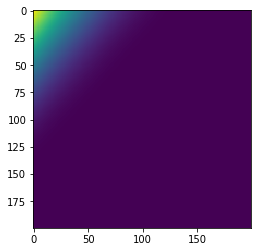

In [159]:
import matplotlib.pyplot as plt

points=np.arange(-1,1,0.01)
xs,ys=np.meshgrid(points,points)
xs=torch.tensor(xs)
ys=torch.tensor(ys)
xl,yl=xs.size()
z=np.zeros((xl,yl))

for i in range(xl):
    for j in range(yl):      
        re=np.zeros(m)
        re[0]=xs[i][j]
        re[1]=ys[i][j]
        re=torch.tensor(re)        
        z[i][j]=model(re.float()).item()

fig=plt.figure()
ax=fig.add_subplot(111)
ax.imshow(z)
plt.show()